# HGDL
    * Hybrid - uses both local and global optimization
    * G - uses global optimizer
    * D - uses deflation
    * L - uses local extremum method
The goal of this is to be modular and robust to a variety of functions
## Imports

Yes, these are all necessary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from math import ceil
import numba as nb
from multiprocessing import cpu_count
from scipy.optimize import minimize

In [2]:
DEBUG = True

## Minimization
### Parameters - passing a bunch of params is unseemly

In [3]:
def defaultParams():
    parameters = np.dtype([('numWorkers','i2'),
                            ('epsilon','f8'),
                            ('radius_squared','f8'),
                            ('maxCount','i4'),
                            ('alpha','f8'),
                            ('unfairness','f8'),
                            ('wildness','f8'),
                            ('minImprovement','f8'),
                            ('N','i4'),
                            ('keepLastX','i2'),
                            ('maxRuns','i4'),
                            ('returnedThreshold','f8'),
                            ('verbose','b'),
                            ('k','i4'),
                            ('numGenerations','i4'),
                          ])

    parameters = np.recarray(1, parameters)
    
    parameters.numWorkers = 1 # -1
    parameters.epsilon = 1e-3
    parameters.maxCount = 100
    parameters.alpha = .1
    parameters.unfairness = 2.5
    parameters.wildness = 1
    parameters.minImprovement = 1.1
    parameters.N = 1 #100
    parameters.keepLastX = 2 #10
    parameters.maxRuns = 1 #10
    parameters.returnedThreshold=0.7
    parameters.verbose = True
    parameters.numGenerations = 0
    
    parameters.k = -2
    parameters.radius_squared = -2.
    
    return parameters[0]

### Define deflation operator and derivatives

In [4]:
@nb.vectorize(nopython=True, cache=True)
def bump_function(dist2center, radius_squared, alpha):
    """
    This actually takes the squared distances to the center, |x-x0|^2
    This is vectorized over distances
    Marcus's bump function
        - find it at https://www.sciencedirect.com/science/article/pii/S037704271730225X
    """
    if dist2center==radius_squared: return 0
    #if dist2center<1e-7: return 10000
    bump_term = np.exp( (-alpha)/(radius_squared - dist2center) + (alpha/radius_squared) )
    return 1./(1.-bump_term)

/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in bump_function
  This is separate from the ipykernel package so we can avoid doing imports until


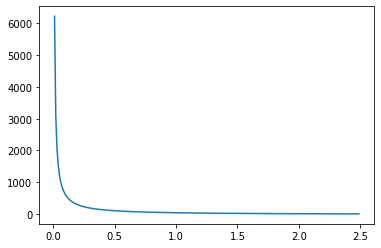

In [5]:
if DEBUG:
    x = np.arange(0, 2.5, 1e-2)
    plt.plot(x, bump_function(x, 2.5, .1))

In [6]:
@nb.vectorize(nopython=True, cache=True)
def bump_derivative(dist2center, radius_squared, alpha):
    """
    This actually takes the squared distances to the center, |x-x0|^2
    This is vectorized over distances
    Marcus's bump function
        - find it at https://www.sciencedirect.com/science/article/pii/S037704271730225X
    """
    if dist2center==radius_squared: return 0
    bump_der = np.exp( (-alpha)/(radius_squared - dist2center) + (alpha/radius_squared) )
    bump_der *= -2*alpha*np.sqrt(dist2center)/np.power(radius_squared-dist2center,2)
    return np.power(bump_function(dist2center,radius_squared,alpha),2)*bump_der

/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in bump_derivative
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in bump_derivative
  This is separate from the ipykernel package so we can avoid doing imports until


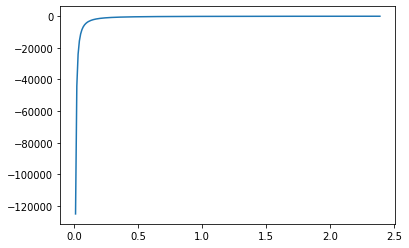

In [7]:
if DEBUG:
    x = np.arange(0, 2.4, 1e-2)
    plt.plot(x, bump_derivative(x, 2.5, .1))

In [8]:
@nb.jit(nopython=True, cache=True)
def deflation_factor(x, minima, radius_squared, alpha):
    """
    This calculates:
        * what minima is this x in range of
        * for the minima in range, what is their deflation factor
        * combined defaltion factor
    """
    # initialize scaling factor
    factor = 1.
    xLen = len(x)
    zLen = len(minima)
    
    # doing all the math in matrix form is much faster 
    c = x-minima[:,:xLen]
    dists2center = np.sum(c*c,axis=1)
    withinRange = dists2center < radius_squared
    return np.prod(bump_function(dists2center[withinRange], radius_squared, alpha)) 

In [9]:
if DEBUG:
    assert np.isinf(deflation_factor(np.ones(3), np.ones((1,3)), 1., 1.,)), "deflation factor is not blowing up"

In [10]:
if DEBUG:
    for i in range(100):
        stop = np.random.random()*100
        alpha = np.random.random()*3 + .1
        x = np.arange(0, stop, 1e-3)
        y = bump_function(x, stop, alpha)
        assert np.array([y[i]<=y[i-1] for i in range(1,len(y))]).all(), "bump function is not monotonically decreasing for alpha "+str(alpha)+' and stop: '+str(stop)
        y = bump_derivative(x, stop, alpha)
        assert np.array([y[i]>=y[i-1] for i in range(2,len(y))]).all(), "bump derivative is not monotonically increasing for alpha "+str(alpha)+' and stop: '+str(stop)


/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in bump_function
  
/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in bump_derivative
  
/home/dperrym2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in bump_derivative
  


In [11]:
@nb.jit(nopython=True, cache=True)
def deflation_derivative(x, minima, radius_squared, alpha):
    """
    This calculates:
        * what minima is this x in range of
        * for the minima in range, what is their deflation factor
        * combined defaltion factor
    """
    # initialize scaling factor
    factor = 1.
    xLen = len(x)
    zLen = len(minima)
    
    # doing all the math in matrix form is much faster 
    c = x-minima[:,:xLen]
    dists2center = np.sum(c*c,axis=1)
    withinRange = dists2center < radius_squared
    return np.prod(bump_derivative(dists2center[withinRange], radius_squared, alpha))

In [12]:
if DEBUG:
    assert np.isinf(deflation_derivative(np.ones(3), np.ones((1,3))+1e-10, 1., 1.,)), "deflation derivative is not blowing up"

### Define checks (necessary bc of parallelism)

In [13]:
@nb.jit(nopython=True, cache=True)
def alreadyFound(newMinima, oldMinima, radius_squared, k):
    """
    check if the new minimum is within range of the old ones
    """
    c = oldMinima[:,:k] - newMinima[0,:k]
    return (np.sum(c*c,1)<radius_squared).any()

In [14]:
if DEBUG:
    assert alreadyFound(10*np.ones((1, 4)), 10*np.ones((1,4)), 10, 3), "not noticing already found minima"

### Define wrappers to make interface generic

In [15]:
def deflated_gradient(x, gradient, minima, radius_squared, alpha, gradientArgs):
    """
    This just combines these two functions together
    """
    return gradient(x, *gradientArgs)*deflation_factor(x, minima, radius_squared, alpha)

In [16]:
def deflated_hessian(x, gradient, hessian, minima, radius_squared, alpha, gradientArgs, hessianArgs):
    """
    This just combines these two functions together
    """
    term1 = hessian(x, *hessianArgs)*deflation_derivative(x, minima, radius_squared, alpha)
    term2 = gradient(x, *gradientArgs)*deflation_factor(x, minima, radius_squared, alpha)
    return term1 + term2

In [71]:
def minimize_wrapper(x0, objective, **kwargs):
    """
    The partial function requires x to be in front, so this just does
    a switcheroo with w(x,f,..) <=> w(f,x)
    """
    return minimize(fun=objective, x0=x0, **kwargs)

In [102]:
if DEBUG:
    A = 10
    d = 2
    def Rastringin(x):
        if args is not (): print(*args)
        return (A*d + np.dot(x,x) - A*np.sum(np.cos(2.*np.pi*x)))

    def Rastringin_gradient(x):
        if args is not (): print(*args)
        grad = np.empty(len(x))
        for i in range(len(grad)):
            grad[i] = (2.*x[i] + A*np.sin(2.*np.pi*x[i])*2.*np.pi)
        return grad

    def Rastringin_hessian(x):
        if args is not (): print(*args)
        hess = np.zeros((len(x),len(x)))
        for i in range(len(hess)):
            hess[i,i] = (2 + A*np.cos(2.*np.pi*x[i])*(4.*np.pi*np.pi))
        return hess

In [107]:
def f(x, *args):
    return x + np.sum(args)

In [108]:
f(1, (3, 3))

7

In [109]:
def g(x, *args):
    return x - np.sum(args)

In [110]:
f(1, (3, 3))

7

In [111]:
x = 2

In [116]:
args = ()

In [117]:
(lambda x,y: x*y)(f(x, *args), g(x, *args))

4.0

In [101]:
if DEBUG:
    
    x = np.zeros(2)
    gradient = Rastringin_gradient
    Hessian = Rastringin_hessian
    objective = Rastringin
    method = 'L-BFGS-B'
    bounds = np.array([[-5, 5],[-5,5]])
    minima = np.empty((0,2))
    radius_squared = 1.
    alpha = 1.
    allArgs = ((1, 2, 3, 4, 5,'\n\n'),(6,7,8,9,10,'\n\n'),(11,12,13,14,15,'\n\n'))
    allArgs = ((),(),())
    parameters = defaultParams()
    parameters.radius_squared = 1e-3

    jac = (lambda f, g, x, arg1, arg2: f(x, *arg1)*g(x, arg2))

    jac = partial(deflated_gradient, gradient=gradient, minima=minima, radius_squared=parameters.radius_squared, 
                  alpha=parameters.alpha, gradientArgs=allArgs[1])

    if Hessian is not None: Hessian = partial(deflated_hessian, gradient=gradient, hessian=Hessian, minima=minima,
                                              radius_squared=parameters.radius_squared, alpha=parameters.alpha, gradientArgs=allArgs[1], hessianArgs=allArgs[2])

    obj = partial(minimize_wrapper, objective=partial(objective, args=allArgs[0]), method=method, jac=jac, hess=Hessian, bounds=bounds, 
                  tol=parameters.radius_squared, options={'maxiter':parameters.maxCount})

    print(obj(x))
    print(jac(x))
    print(Hessian(x))
    
#    print(minimize_wrapper(x, fun=objective, method=method, jac=jac, hess=Hessian, 
#                           bounds=bounds, tol=parameters.radius_squared, options={'maxiter':parameters.maxCount}, args=allArgs[0]))

1 2 3 4 5 




TypeError: Rastringin_gradient() takes 2 positional arguments but 7 were given

In [88]:
parameters.radius_squared

0.001

In [52]:
parameters.radius_squared = 1e-3

In [54]:
minimize(x0=x, fun=Rastringin, jac=Rastringin_gradient, hess=Rastringin_hessian, bounds=bounds, tol=parameters.radius_squared, method='Newton-CG')

/home/dperrym2/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)


     fun: 0.0
     jac: array([0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 1
     nit: 1
    njev: 2
  status: 0
 success: True
       x: array([0., 0.])

### Define parallelized deflated local stepdefaultParams

In [25]:
def walk_individuals(individuals, bounds, objective, gradient, Hessian, workers, parameters, method, allArgs, minima=None):
    """
    Do the actual iteration through the deflated local optimizer
    """
    
    if minima is None: minima = np.empty((0, parameters.k+1))
    
    newMinima = np.empty((0, parameters.k+1))
        
    for i in range(parameters.maxRuns):
        numNone = 0
        
        print(allArgs)
        # construct the jacobian, hessian, and objective. This is inside the loop because of the minima
        jac = partial(deflated_gradient, gradient=gradient, minima=minima, radius_squared=parameters.radius_squared, 
                      alpha=parameters.alpha, gradientArgs=allArgs[1])
        if Hessian is not None: Hessian = partial(deflated_hessian, gradient=gradient, hessian=Hessian, minima=minima,
                                                  radius_squared=parameters.radius_squared, alpha=parameters.alpha, gradientArgs=allArgs[1], hessianArgs=allArgs[2])
        obj = partial(minimize_wrapper, fun=objective, method=method, jac=jac, hess=Hessian, bounds=bounds, 
                      tol=parameters.radius_squared, options={'maxiter':parameters.maxCount}, args=allArgs[0])
        
        print(obj(individuals[i]).x)
        print(jac(individuals[i]))
        print(Hessian(individuals[i]))
        
        # chunk up and iterate through
        #walkerOutput = workers.imap_unordered(objective, individuals, chunksize=ceil(0.3*len(individuals)/cpu_count()))
        for i in range(len(individuals)):
            
            x_found = obj(individuals[i])
            
        # process results
        #for i,x_found in enumerate(walkerOutput):
            if x_found.success==False: 
                numNone += 1
                print('no success')
                if numNone/parameters.N > parameters.returnedThreshold:
                    return minima
            else:
                if not in_bounds(x_found.x, bounds): 
                    numNone += 1
                    print('not in bounds')
                    if numNone/parameters.N > parameters.returnedThreshold:
                        return minima                        
                else:
                    newMinima = np.array([*x_found.x, x_found.fun]).reshape(1,-1)
                    if not alreadyFound(newMinima, minima, radius_squared=parameters.radius_squared, k=k): 
                        minima = np.concatenate((newMinima, minima), axis=0)
    return minima

### Define a global optimizer

In [26]:
def Procreate(X, y, parameters):
    """
    Input:
    X is the individuals - points on a surface
    y is the performance - f(X)
    
    Parameters:
    unfairness is a metric from (1,infinity), where higher numbers skew more towards well performing individuals having more kids
    cauchy wildness is a scaling factor for the standard cauchy distribution, where higher values mean less variation
        (although it's still a nonstationary function...)
    
    Notes:
    some of the children can (and will) be outside of the bounds!
    """
    
    # normalize the performances to (0,1)
    p = y - np.amin(y)
    maxVal = np.amax(p)
    if maxVal == 0: p = np.ones(len(p))/len(p) # if the distribution of performance has no width, give everyone an equal shot
    else: p /= maxVal

    #This chooses from the sample based on the power law, allowing replacement means that the the individuals can have multiple kids
    p = parameters.unfairness*np.power(p,parameters.unfairness-1)
    p /= np.sum(p)
    if np.isnan(p).any():
        return p, X, y
    moms = np.random.choice(np.arange(len(p)), parameters.N, replace=True, p = p)
    dads = np.random.choice(np.arange(len(p)), parameters.N, replace=True, p = p)
    
    # calculate a perturbation to the median of each individuals parents
    perturbation = np.random.standard_normal(size=(parameters.N,parameters.k))
    perturbation *= parameters.wildness
    
    # the children are the median of their parents plus a perturbation (with a chance to deviate wildly)
    children = (X[moms]+X[dads])/2. + perturbation*(X[moms]-X[dads])

    return children

### Check boundary conditions

In [27]:
def in_bounds(x, bounds):
    if (bounds[:,1]-x > 0).all() and (bounds[:,0] - x < 0).all(): return True
    return False

### Sample within bounds

In [28]:
def random_sample(N,bounds,parameters):
    sample = np.random.random((N,parameters.k))
    sample *= bounds[:,1]-bounds[:,0]
    sample += bounds[:,0]
    return sample

### Wrap everything together

In [29]:
import warnings

In [30]:
#warnings.simplefilter("error")

In [16]:
def HXDY(fun, bounds, jac, allArgs=((), (), ()), method='Newton-CG', hess=None, x0=None, 
         parameters=None, rms = .01, extraStoppingCriterion=None ):
    
    # Initialization
    if parameters == None:
        parameters = defaultParams()

    parameters.k = len(bounds)
 
    if parameters.numWorkers == -1: parameters.numWorkers = cpu_count()

    if x0 is None: starts = random_sample(parameters.N,bounds,parameters)
    else: starts = x0
        
    objective = fun
    hessian = hess
    gradient = jac
    parameters.radius_squared = parameters.k*(rms**2)
    
    if extraStoppingCriterion is None: extraStoppingCriterion = lambda x: True
        
    workers = Pool(parameters.numWorkers)
     
    res = walk_individuals(starts, bounds, objective, gradient, hessian, workers, parameters, allArgs=allArgs, method=method)
    
    parameters.numGenerations = 0
    
    # processing
    res = res[res[:,-1].argsort()]
    best = np.inf*np.ones(parameters.keepLastX); 
    if len(res)==0: best[0] = np.nan_to_num(np.inf)-1
    else: best[0] = res[0,-1]
        
    while not np.allclose(best[0],best) and extraStoppingCriterion(res):

        parameters.numGenerations += 1

        if res.shape[0]!=0: 
            new_starts = Procreate(res[:,:parameters.k], res[:,-1], parameters)
            for i in range(len(new_starts)): 
                if not in_bounds(new_starts[i], bounds): new_starts[i] = random_sample(1,bounds,parameters)
        else:
            new_starts = random_sample(parameters.N,bounds,parameters)

        res = walk_individuals(new_starts, bounds, objective, gradient, hessian, workers, parameters, minima=res, allArgs=allArgs, method=method)
        
        res = res[res[:,-1].argsort()]
        if res.shape[0]!=0: best[parameters.numGenerations%parameters.keepLastX] = res[0,-1]
        if parameters.verbose: print(best.round())
        
        plt.scatter(res[:,0], res[:,1])
        plt.show()
        
    workers.close()
    return res